In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0532.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0282.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1401.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0914.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0691.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0972.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0818.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0463.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0930.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1323.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1347.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1354.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0704.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0

**GETTING OUT THE DIRECTORIES**


In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir  = '/kaggle/input/brain-tumor-mri-dataset/Testing'

**FETCHING THE DEPENDENCIES**

Here we will try a segmentation model and will observe how this work. We found a very little use of them but with a fully connected layer how it behaves will be observed. 

In [24]:
!pip install segmentation-models

**AUGMENTATION and SPLITTING**

In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Medical Standard Augmentation Performed

train_datagen = ImageDataGenerator(               
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=(0.95, 1.05),
    brightness_range=(0.9, 1.1),
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

#Splitting The Train and Test Data

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [26]:
import os

#Setting The Environment as per Required

os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm

#For Unet Backbone Will be Used The Famous Resnet-34. Mostly Used in Medical Imaging

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

**LOSS FUNCTION SELECTION**

We may use the dice loss though out target is categorizing. We will experiment it. If it doesnot feel suitable we will use the common 
categorical crossentropy.

In [27]:
import tensorflow as tf

def softmax_dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # get number of dims
    axes = list(range(len(y_true.shape)-1))  

    intersection = tf.reduce_sum(y_true * y_pred, axis=axes)
    union = tf.reduce_sum(y_true + y_pred, axis=axes)

    dice = (2. * intersection + smooth) / (union + smooth)

    return 1 - tf.reduce_mean(dice)

**MODEL ARCHITECTURE**

In [28]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,BatchNormalization,Dropout
import segmentation_models as sm

conv_base = sm.Unet(
    backbone_name='resnet34', 
    input_shape=(256,256, 3)
)

'''
from tensorflow.keras.applications import EfficientNetB0
conv_base = EfficientNetB0(include_top=False, input_shape=(256, 256, 3))
'''

#conv_base.trainable = False

#

model = Sequential([
    conv_base,

    Flatten(), 
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dense(4, activation='softmax')
])

#Two optimizers will be tested. Adadelta and AdamW. Adadelta is kinda self-regulating, for stabilization it will be prefered

from tensorflow.keras.optimizers import Adadelta, AdamW

optimizer = Adadelta(learning_rate=0.01)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy','recall','precision'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_7 (Functional)       │ (None, 256, 256, 1)    │    24,456,154 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,272,974 (157.44 MB)

 Trainable params: 41,254,760 (157.37 MB)

 Non-trainable params: 18,214 (71.15 KB)

**NECESSARY CALLBACKS**

Learning Rate Scheduler if we use AdamW. 
EarlyStopping will never be used for stopping training early. Rather we will use it to store the best values and to use instantly. We will monitor the val_loss and target is to minimize this.  

In [29]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=1000,               #Forcefully done so that all the epochs can run ok
    restore_best_weights=True,
    verbose=1
)

**TRAINING**

In [31]:
history = model.fit(train_gen,epochs=100,validation_data=test_gen, verbose=1, callbacks=[early_stop], batch_size=16)

Epoch 1/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 214s 977ms/step - accuracy: 0.3167 - loss: 1.7135 - precision: 0.3208 - recall: 0.1872 - val_accuracy: 0.2349 - val_loss: 2.3272 - val_precision: 0.2363 - val_recall: 0.2326
Epoch 2/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 110s 610ms/step - accuracy: 0.4699 - loss: 1.3095 - precision: 0.5404 - recall: 0.3278 - val_accuracy: 0.2845 - val_loss: 1.7772 - val_precision: 0.2712 - val_recall: 0.1632
Epoch 3/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 107s 593ms/step - accuracy: 0.6283 - loss: 0.9857 - precision: 0.7092 - recall: 0.5062 - val_accuracy: 0.2586 - val_loss: 2.0439 - val_precision: 0.2349 - val_recall: 0.1686
Epoch 4/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 107s 595ms/step - accuracy: 0.7037 - loss: 0.8284 - precision: 0.7761 - recall: 0.5867 - val_accuracy: 0.3875 - val_loss: 1.7774 - val_precision: 0.4083 - val_recall: 0.3364
Epoch 5/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 105s 584ms/step - accuracy: 0.7585 - loss: 0.7189 - precision: 0.8178 - recall: 0.6523 - val_accura

**NECESSARY PLOTS**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

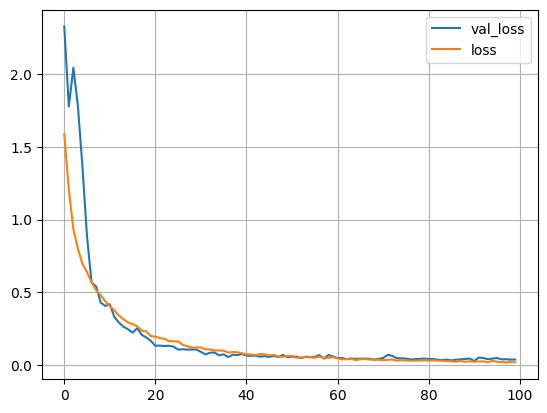

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.lineplot(history.history['val_loss'], label='val_loss')
sns.lineplot(history.history['loss'], label='loss')
plt.grid()
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

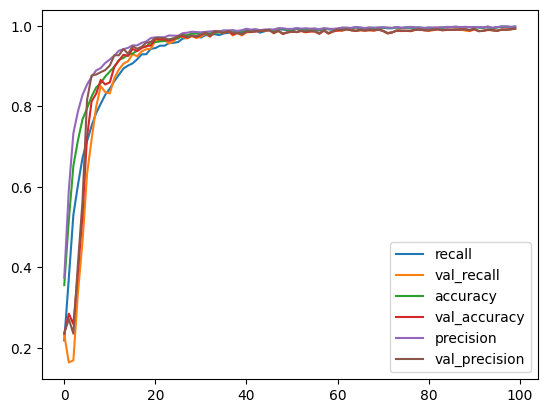

In [54]:
sns.lineplot(history.history['recall'], label='recall')
sns.lineplot(history.history['val_recall'], label='val_recall')
sns.lineplot(history.history['accuracy'], label='accuracy')
sns.lineplot(history.history['val_accuracy'], label='val_accuracy')
sns.lineplot(history.history['precision'], label='precision')
sns.lineplot(history.history['val_precision'], label='val_precision')
plt.legend()
plt.show()

**BEST EVALUATION RESULTS**

In [36]:
results = model.evaluate(test_gen, verbose=1)
print(results)

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.9933 - loss: 0.0179 - precision: 0.9945 - recall: 0.9933
[0.027441486716270447, 0.9916094541549683, 0.9916094541549683, 0.9931245446205139]


**RESULT WITH BEST PARAMETERS**

Found 1311 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 193ms/step


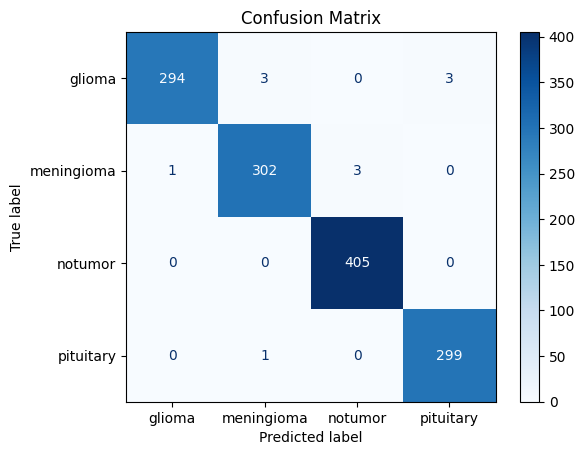

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

y_pred_prob = model.predict(test_gen)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_gen.classes

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_gen.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

**RESULTS WITH AFTER FINDING THE BEST THRESHOLDS**

Found 1311 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step
Class 0 optimal threshold: 0.02
Class 1 optimal threshold: 0.43
Class 2 optimal threshold: 0.49
Class 3 optimal threshold: 0.92
Accuracy with optimal thresholds: 0.9977
Precision with optimal thresholds: 0.9977
Recall with optimal thresholds: 0.9977


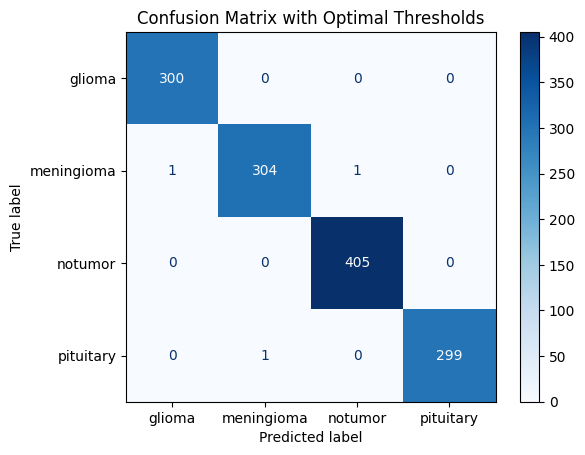

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score

test_dir = "/kaggle/input/brain-tumor-mri-dataset/Testing" 
batch_size = 32
target_size = (256, 256)

test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

y_pred_prob = model.predict(test_gen)
y_true = test_gen.classes
num_classes = len(test_gen.class_indices)
y_true_onehot = to_categorical(y_true, num_classes=num_classes)

optimal_thresholds = []

for i in range(num_classes):
    best_thresh = 0.0
    best_f1 = 0.0
    for thresh in np.arange(0, 1.01, 0.01):
        y_pred_class = (y_pred_prob[:, i] >= thresh).astype(int)
        f1 = f1_score(y_true_onehot[:, i], y_pred_class)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
    optimal_thresholds.append(best_thresh)
    print(f"Class {i} optimal threshold: {best_thresh:.2f}")

y_pred_thresh = np.zeros_like(y_pred_prob, dtype=int)
for i in range(num_classes):
    y_pred_thresh[:, i] = (y_pred_prob[:, i] >= optimal_thresholds[i]).astype(int)

y_pred_final = np.argmax(y_pred_thresh, axis=1)
acc = accuracy_score(y_true, y_pred_final)
pre = precision_score(y_true, y_pred_final, average='weighted')
rec = recall_score(y_true, y_pred_final, average='weighted')
print(f"Accuracy with optimal thresholds: {acc:.4f}")
print(f"Precision with optimal thresholds: {pre:.4f}")
print(f"Recall with optimal thresholds: {rec:.4f}")

cm = confusion_matrix(y_true, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_gen.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix with Optimal Thresholds")
plt.show()

**SAMPLE RESULT**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


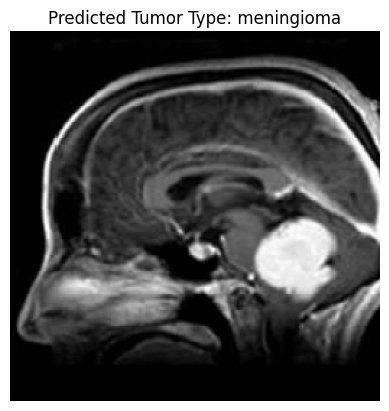

In [53]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

img_path = "/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0030.jpg"  
target_size = (256, 256)              
class_indices = {v: k for k, v in test_gen.class_indices.items()}  

img = image.load_img(img_path, target_size=target_size)
img_array = image.img_to_array(img)
img_array_rescaled = img_array / 255.0            
img_array_batch = np.expand_dims(img_array_rescaled, axis=0) 

y_pred_prob = model.predict(img_array_batch)
y_pred_thresh = (y_pred_prob >= optimal_thresholds).astype(int)
y_pred_class = np.argmax(y_pred_thresh, axis=1)[0]
predicted_class_name = class_indices[y_pred_class]

plt.imshow(np.array(img).astype('uint8'))  
plt.axis('off')
plt.title(f"Predicted Tumor Type: {predicted_class_name}")
plt.show()

ESHAYAT ZAMIL SHARAF
imsharaf10@gmail.com
u2301002@student.cuet.ac.bd

Trust the result 99.16 of accuracy. This is more optimistic and reliable. 